*Baseline 에 시각화 코드뿐입니다...*

## Import

In [3]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

## Fixed Random-Seed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_df = pd.read_csv('/content/sample_data/train.csv')
test_df = pd.read_csv('/content/sample_data/test.csv')
international_trade = pd.read_csv('/content/sample_data/international_trade.csv')

### Description

#### train.csv
    2019년 01월 01일부터 2023년 03월 03일까지의 유통된 품목의 가격 데이터
    - item: 품목 코드
        - TG : 감귤
        - BC : 브로콜리
        - RD : 무
        - CR : 당근
        - CB : 양배추
    - corporation : 유통 법인 코드
        - 법인 A부터 F 존재
    - location : 지역 코드
        - J : 제주도 제주시
        - S : 제주도 서귀포시
    - supply(kg) : 유통된 물량, kg 단위
    - price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위

#### international_trade.csv
    - 관련 품목 수출입 정보
    - 중량 단위 kg
    - 금액 단위 천 달러

#### test.csv
    2023년 03월 04일부터 2023년 03월 31일까지의 데이터

#### sample_submission.csv
    - 제출을 위한 양식
    - 2023년 03월 04일부터 2023년 03월 31일까지의 price(원/kg)을 예측
    - ID는 품목, 유통 법인, 지역 코드로 구성된 식별자
    - 해당 ID에 맞춰 price(원/kg) 예측값을 answer 컬럼에 기입해야 함

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           59397 non-null  object 
 1   timestamp    59397 non-null  object 
 2   item         59397 non-null  object 
 3   corporation  59397 non-null  object 
 4   location     59397 non-null  object 
 5   supply(kg)   59397 non-null  float64
 6   price(원/kg)  59397 non-null  float64
 7   year         59397 non-null  int64  
 8   month        59397 non-null  int64  
 9   day          59397 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 4.5+ MB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1092 entries, 0 to 1091
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           1092 non-null   object
 1   timestamp    1092 non-null   object
 2   item         1092 non-null   object
 3   corporation  1092 non-null   object
 4   location     1092 non-null   object
 5   year         1092 non-null   int64 
 6   month        1092 non-null   int64 
 7   day          1092 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 68.4+ KB


In [ ]:
international_trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1274 entries, 0 to 1273
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   기간      1274 non-null   object
 1   품목명     1274 non-null   object
 2   수출 중량   1274 non-null   int64 
 3   수출 금액   1274 non-null   int64 
 4   수입 중량   1274 non-null   int64 
 5   수입 금액   1274 non-null   int64 
 6   무역수지    1274 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 69.8+ KB


In [ ]:
display(train_df.describe().T)
display(test_df.describe().T)

,count,mean,std,min,25%,50%,75%,max
supply(kg),59397.0,11894.525187,52263.999831,0.0,0.0,0.0,3800.0,1222800.0
price(원/kg),59397.0,1131.680674,2029.941445,0.0,0.0,0.0,1519.0,20909.0
year,59397.0,2020.601445,1.201092,2019.0,2020.0,2021.0,2022.0,2023.0
month,59397.0,6.320420,3.519942,1.0,3.0,6.0,9.0,12.0
day,59397.0,15.685489,8.804446,1.0,8.0,16.0,23.0,31.0


,count,mean,std,min,25%,50%,75%,max
year,1092.0,2023.0,0.000000,2023.0,2023.00,2023.0,2023.00,2023.0
month,1092.0,3.0,0.000000,3.0,3.00,3.0,3.00,3.0
day,1092.0,17.5,8.081448,4.0,10.75,17.5,24.25,31.0


In [ ]:
display(train_df.describe(include='object').T)
display(test_df.describe(include='object').T)

,count,unique,top,freq
ID,59397,59397,RD_F_J_20230303,1
timestamp,59397,1523,2023-03-03,39
item,59397,5,TG,15230
corporation,59397,6,A,13707
location,59397,2,J,35029


,count,unique,top,freq
ID,1092,1092,RD_F_J_20230331,1
timestamp,1092,28,2023-03-04,39
item,1092,5,TG,280
corporation,1092,6,A,252
location,1092,2,J,644


In [ ]:
display(international_trade.describe().T)
display(international_trade.describe(include='object').T)

,count,mean,std,min,25%,50%,75%,max
수출 중량,1274.0,2.005844e+05,9.669554e+05,0.0,0.0,125.5,15565.25,20949417.0
수출 금액,1274.0,3.604254e+02,1.689359e+03,0.0,0.0,1.0,31.00,16278.0
수입 중량,1274.0,1.255735e+06,3.680257e+06,0.0,0.0,29269.5,1022695.50,49759137.0
수입 금액,1274.0,1.548220e+03,5.844806e+03,0.0,0.0,89.5,1253.00,84118.0
무역수지,1274.0,-1.187790e+03,6.171655e+03,-84117.0,-1240.5,-61.5,9.00,16278.0


,count,unique,top,freq
기간,1274,50,2022-08,29
품목명,1274,34,방울다다기 양배추,50


## Visualization

In [ ]:
train_df.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'supply(kg)',
       'price(원/kg)', 'year', 'month', 'day'],
      dtype='object')

In [ ]:
test_df.columns

Index(['ID', 'timestamp', 'item', 'corporation', 'location', 'year', 'month',
       'day'],
      dtype='object')

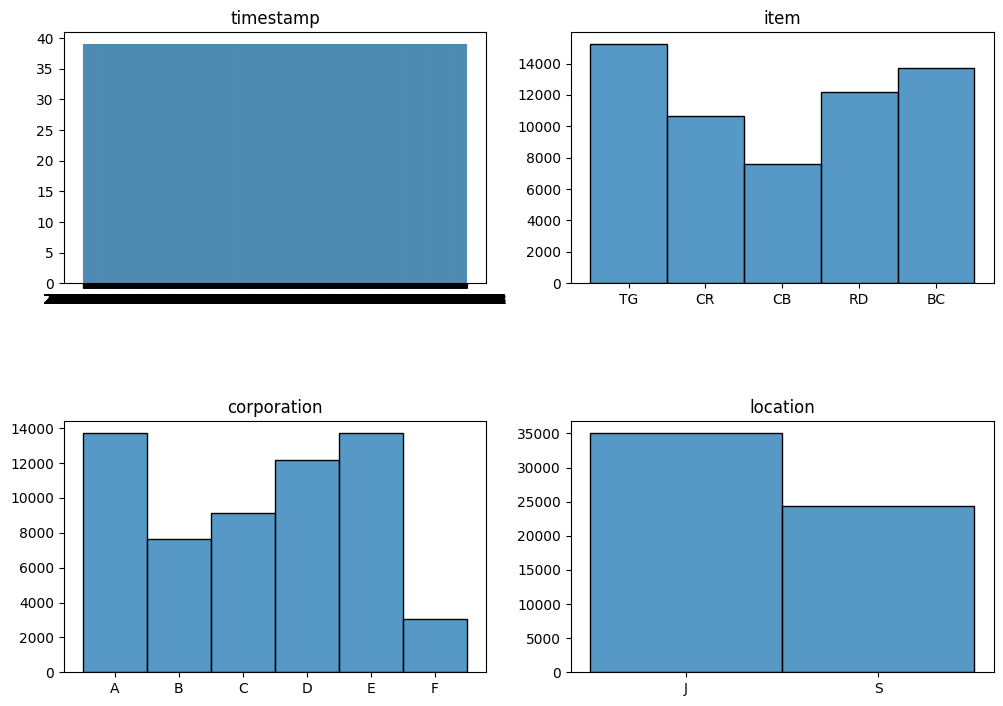

In [ ]:
cols = ['timestamp', 'item', 'corporation', 'location']

plt.figure(figsize=(12, 8))

for i in range(len(cols)):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(cols[i])
    sns.histplot(train_df[cols[i]])
    plt.title(cols[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

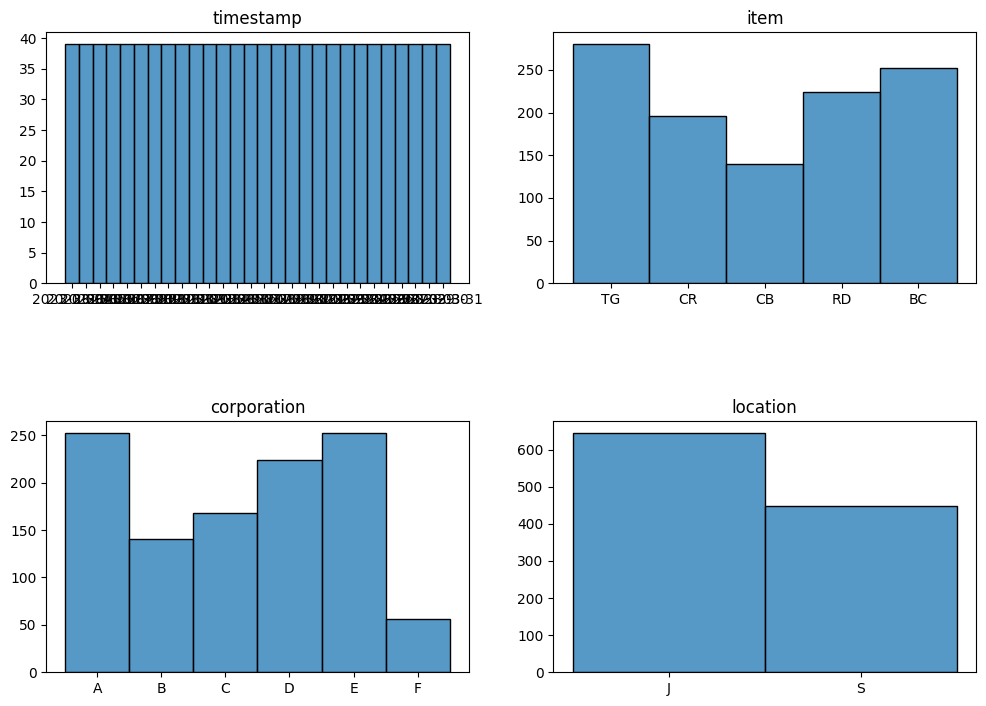

In [ ]:
cols = ['timestamp', 'item', 'corporation', 'location']

plt.figure(figsize=(12, 8))

for i in range(len(cols)):
    plt.subplot(2, 2, i+1)
    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.2, hspace=0.55)
    plt.title(cols[i])
    sns.histplot(test_df[cols[i]])
    plt.title(cols[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

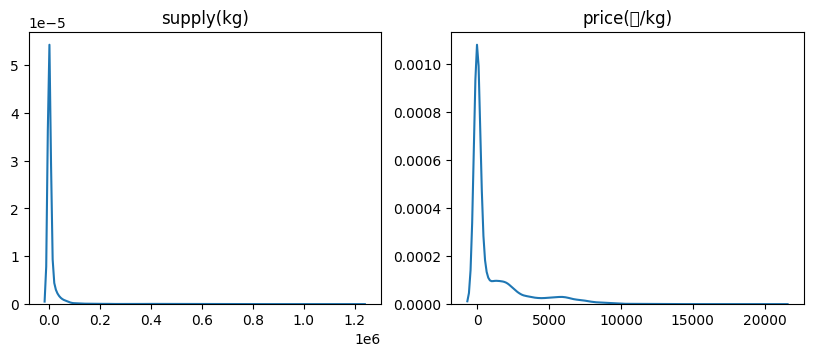

In [ ]:
col = ['supply(kg)', 'price(원/kg)']

plt.figure(figsize=(10, 8))

for i in range(len(col)):
    plt.subplot(2, 2, i+1, )
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)
    plt.title(col[i])
    sns.kdeplot(train_df[col[i]])
    plt.title(col[i])
    plt.xlabel(None)
    plt.ylabel(None)
plt.show()

In [7]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

In [8]:
train_df["year"] = train_df["timestamp"].map(lambda x :str(x.year))
train_df["month"] = train_df["timestamp"].map(lambda x :str(x.month))
train_df["day"] = train_df["timestamp"].map(lambda x :str(x.day))

test_df["year"] = test_df["timestamp"].map(lambda x :str(x.year))
test_df["month"] = test_df["timestamp"].map(lambda x :str(x.month))
test_df["day"] = test_df["timestamp"].map(lambda x :str(x.day))

<Axes: xlabel='month', ylabel='supply(kg)'>

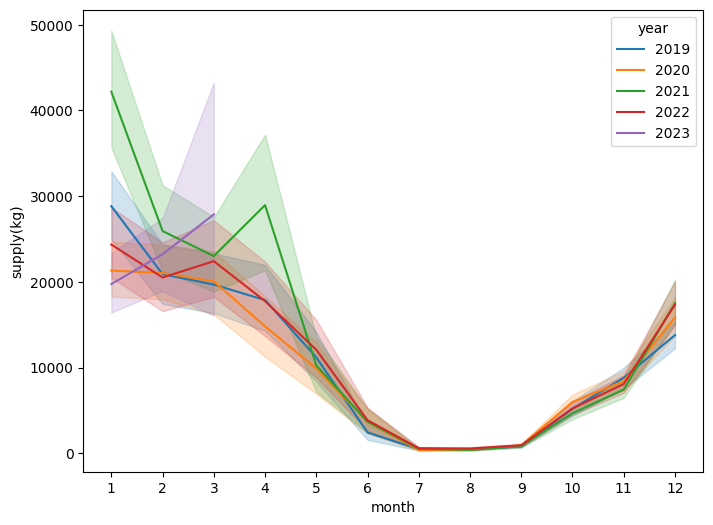

In [ ]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=train_df, x='month', y = 'supply(kg)', hue='year')

<Axes: xlabel='month', ylabel='price(원/kg)'>

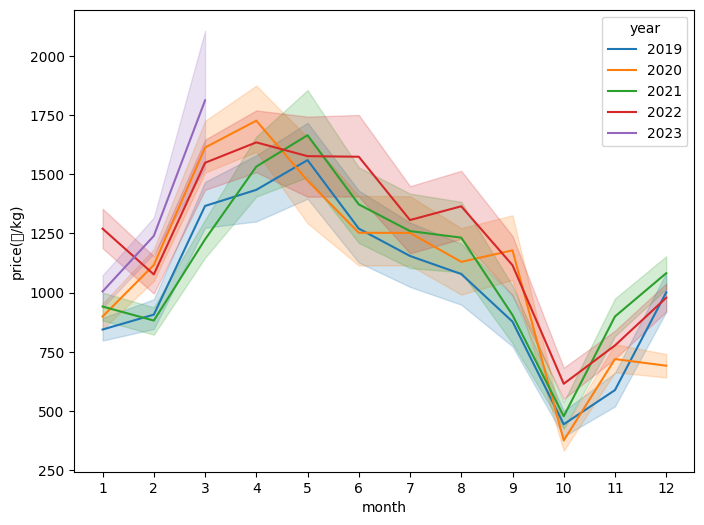

In [ ]:
plt.figure(figsize=(8, 6))

sns.lineplot(data=train_df, x='month', y = 'price(원/kg)', hue='year')

In [13]:
train_df['item'].value_counts()

item
TG    15230
BC    13707
RD    12184
CR    10661
CB     7615
Name: count, dtype: int64

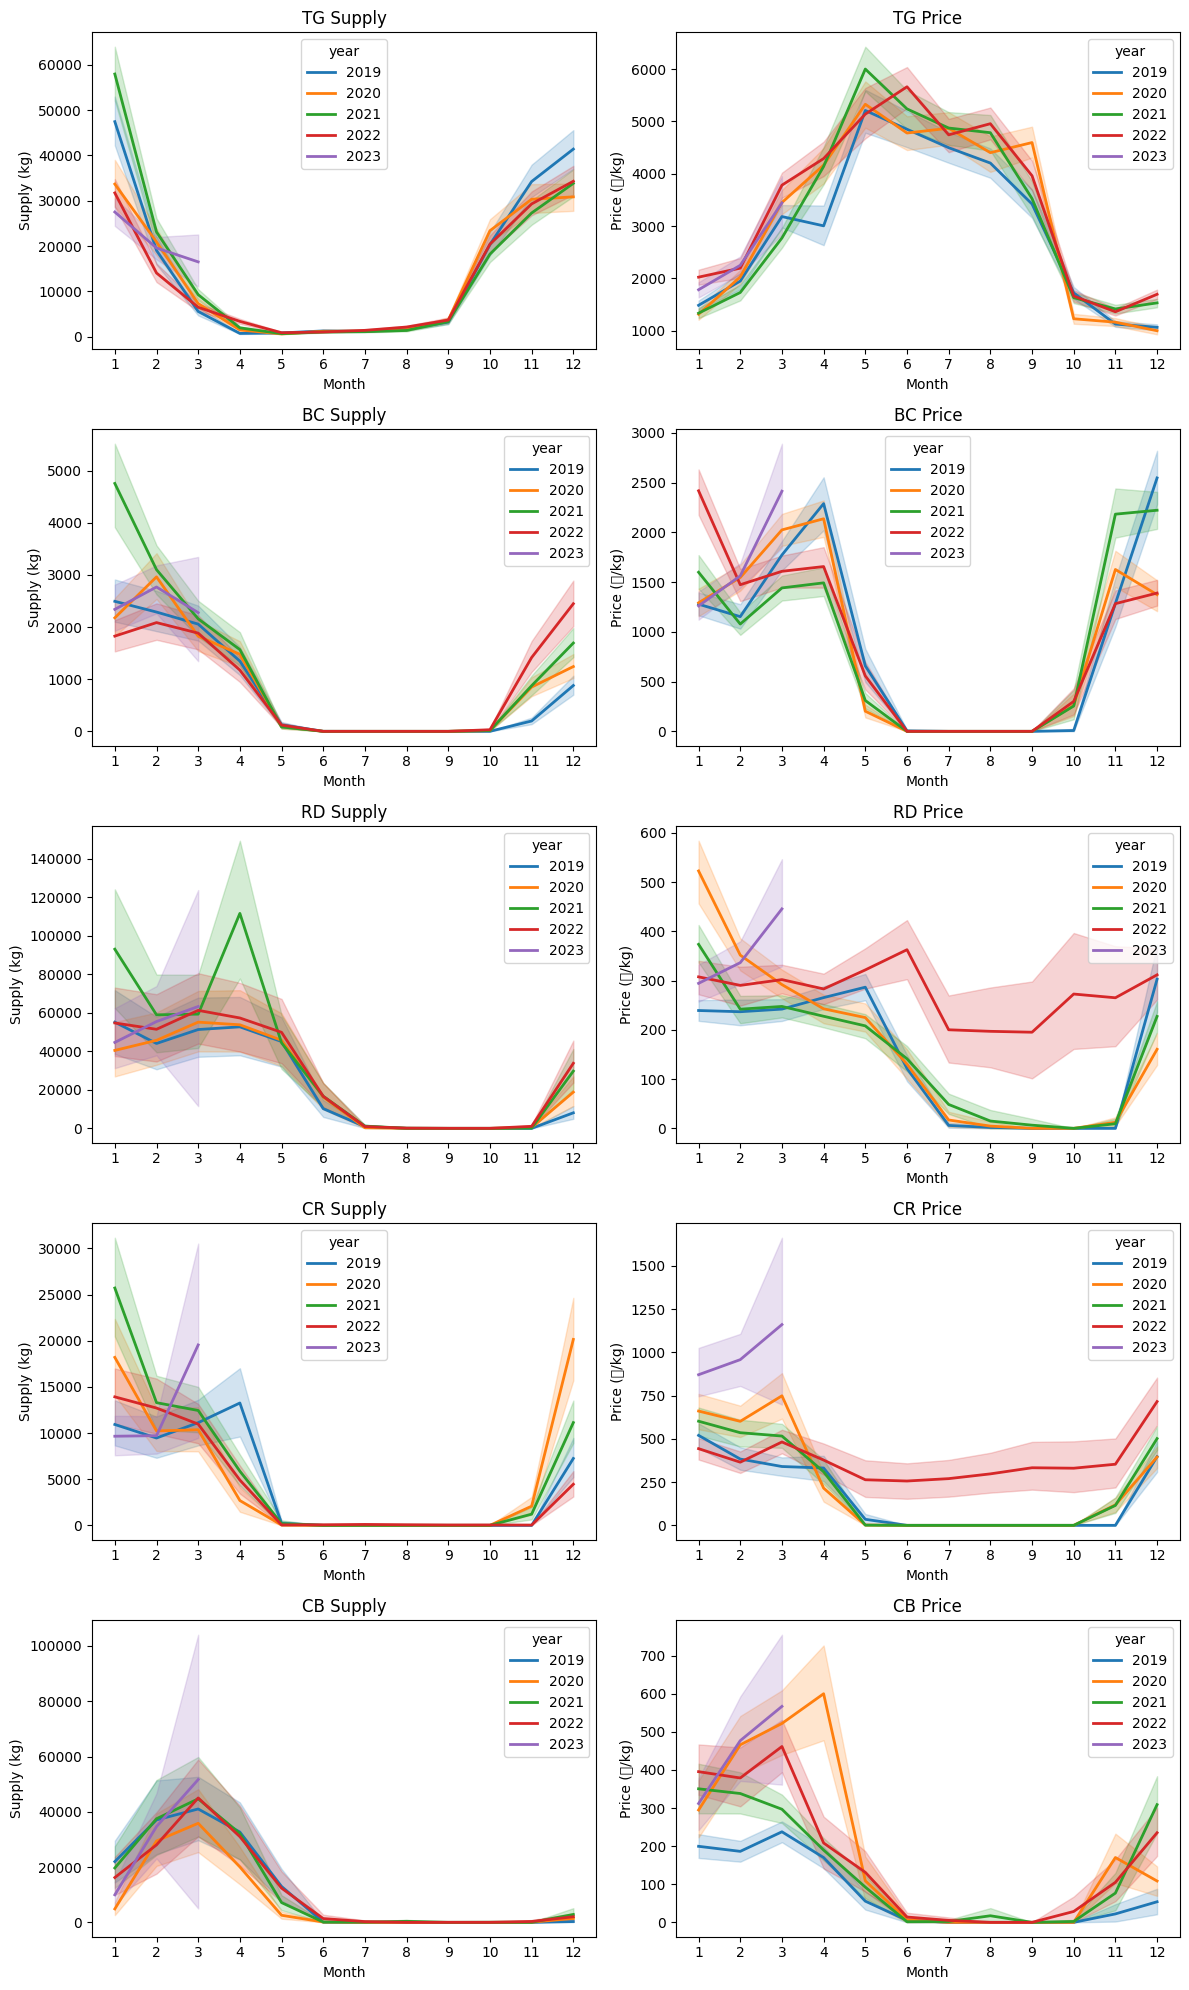

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 20))  # Adjusted figure size for 5x2 grid

item = ['TG', 'BC', 'RD', 'CR', 'CB']
num_items = len(item)

for idx, i in enumerate(item, 1):
    # First plot: Supply
    plt.subplot(num_items, 2, 2 * idx - 1)

    new_train = train_df[train_df['item']==i]
    sns.lineplot(data=new_train, x='month', y='supply(kg)', hue='year', linewidth=2)

    plt.title(f'{i} Supply')
    plt.xlabel('Month')
    plt.ylabel('Supply (kg)')

    # Second plot: Price
    plt.subplot(num_items, 2, 2 * idx)

    sns.lineplot(data=new_train, x='month', y='price(원/kg)', hue='year', linewidth=2)

    plt.title(f'{i} Price')
    plt.xlabel('Month')
    plt.ylabel('Price (원/kg)')

plt.tight_layout()
plt.show()


## Data Pre-Processing

In [ ]:
# #시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
# train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
# train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
# train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

# test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
# test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
# test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

In [ ]:
#학습에 사용하지 않을 변수들을 제거합니다
train_x = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_y = train_df['price(원/kg)']

test_x = test_df.drop(columns=['ID', 'timestamp'])

In [ ]:
#질적 변수들을 수치화합니다
qual_col = ['item', 'corporation', 'location']

for i in qual_col:
    le = LabelEncoder()
    train_x[i]=le.fit_transform(train_x[i])
    test_x[i]=le.transform(test_x[i]) #test 데이터에 대해서 fit하는 것은 data leakage

print('Done.')

Done.


## Regression Model Fit

In [ ]:
model = RandomForestRegressor()
model.fit(train_x, train_y)

RandomForestRegressor()

In [ ]:
preds = model.predict(test_x)

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [ ]:
submission['answer'] = preds
submission

,ID,answer
0,TG_A_J_20230304,3636.64
1,TG_A_J_20230305,4109.28
2,TG_A_J_20230306,401.82
3,TG_A_J_20230307,3277.93
4,TG_A_J_20230308,3067.03
...,...,...
1087,RD_F_J_20230327,271.27
1088,RD_F_J_20230328,441.28
1089,RD_F_J_20230329,439.31
1090,RD_F_J_20230330,436.00


In [ ]:
submission.to_csv('./baseline_submission.csv', index=False)